# Exploratory Data Analysis And Data Pre-processing


**Exploratory Data Analysis (EDA)** and **Data Pre-processing** are the two critical steps before starting to analysis data with deep learning. Exploratory Data Analysis performs the initial analysis which allows us to achieve overall understanding on the dataset and the relationship between variables while the data preproceesing helps to clean and enhance the raw dataset to make it ready for the further steps.

Generally, EDA and data pre-processing are mutually influenced and alternated in the early stage of data analysis.


In [44]:
import pandas as pd
import json

In [45]:
# read the corespondence between id and genre
with open("data_NLP/genre_id_info.txt", "r") as f:
    content = json.loads(f.read())
    id2genre = {str(i["id"]): i["name"] for i in content}
    id2genre = dict(sorted(id2genre.items(), key=lambda x: int(x[0])))

data = pd.DataFrame(columns=["id", "genre_ids", "overview"])
# dtype={"id": int, "overview": str}
for key in id2genre.keys():
    data_temp = pd.read_csv(
        f"data_NLP/{key}.csv",
        sep=",",
        # dtype={"id": int, "genre_ids": object, "overview": str},
    )
    data = pd.concat([data, data_temp[["id", "genre_ids", "overview"]]], axis=0)

print(f"Dataset Original Shape: {data.shape}")

Dataset Original Shape: (114000, 3)


Fist of all, we need to clean the raw dataset. Common methods of data preprocessing include removing duplicate records, handling missing values, processing outliers and so on.


In [46]:
# drop duplicates
data_dup = data[data.duplicated()]
data.drop_duplicates(subset="id", inplace=True, ignore_index=True)
print(
    f"Number of Duplicates: {data_dup.shape[0]}, Current Dataset Shape: {data.shape}",
    end="\n\n",
)

# remove missing values
print(f"Missing Data:\n{data.isna().sum()}")
data.dropna(inplace=True)
print(f"Current Dataset Shape: {data.shape}", end="\n\n")

# discard too short overviews (which may include missing values like 'unknown overview')
print(f"Overview Description:\n{data['overview'].describe()}")
data_short = data[data["overview"].str.len() < 50]
data = data[~(data["overview"].str.len() < 50)]
print(
    f"Number of Short Overview: {data_short.shape[0]}, Current Dataset Shape: {data.shape}"
)

Number of Duplicates: 43820, Current Dataset Shape: (70180, 3)

Missing Data:
id              0
genre_ids       0
overview     1978
dtype: int64
Current Dataset Shape: (68202, 3)

Overview Description:
count                  68202
unique                 68091
top       No overview found.
freq                      28
Name: overview, dtype: object
Number of Short Overview: 762, Current Dataset Shape: (67440, 3)


Given that one movie may belong to multiple genres, we need to split the `genre_ids` attribute into different columns where a value of 1 means that the movie belongs to the genre and 0 means that it does not.


In [47]:
for id in id2genre.keys():
    data[id] = data["genre_ids"].map(lambda x: 1 if id in x else 0)
print(data.head())

       id        genre_ids                                           overview  \
0  436270     [28, 12, 14]  Nearly 5,000 years after he was bestowed with ...   
1  960704     [28, 12, 14]  The Elric brothers’ long and winding journey c...   
2  791155    [878, 12, 28]  While hanging out after school, Charlie and hi...   
3  759507     [28, 12, 53]  A man wakes in a hospital with no memory, and ...   
4  532639  [14, 12, 10751]  A wooden puppet embarks on a thrilling adventu...   

   12  14  16  18  27  28  35  ...  53  80  99  878  9648  10402  10749  \
0   1   1   0   0   0   1   0  ...   0   0   0    0     0      0      0   
1   1   1   0   0   0   1   0  ...   0   0   0    0     0      0      0   
2   1   0   0   0   0   1   0  ...   0   0   0    1     0      0      0   
3   1   0   0   0   0   1   0  ...   1   0   0    0     0      0      0   
4   1   1   0   0   0   0   0  ...   0   0   0    0     0      0      0   

   10751  10752  10770  
0      0      0      0  
1      0    

Now, we can try to "take a peek" at the data to understand more about what it represents and how to apply it.


## Distribution of Data

Firstly we want to check the number of movies in each genre to make sure that the number does not vary much, as a result of which, we don't have to worry about the imbalanced classification problem too much. The pie chart is one of the common ways to visualize the composition ratio while the tree map can demonstrate the relationship between the magnitude of the quantities more clearly.

The pie chart and tree map of the number are shown as below. And it turns out that numbers are relatively even.


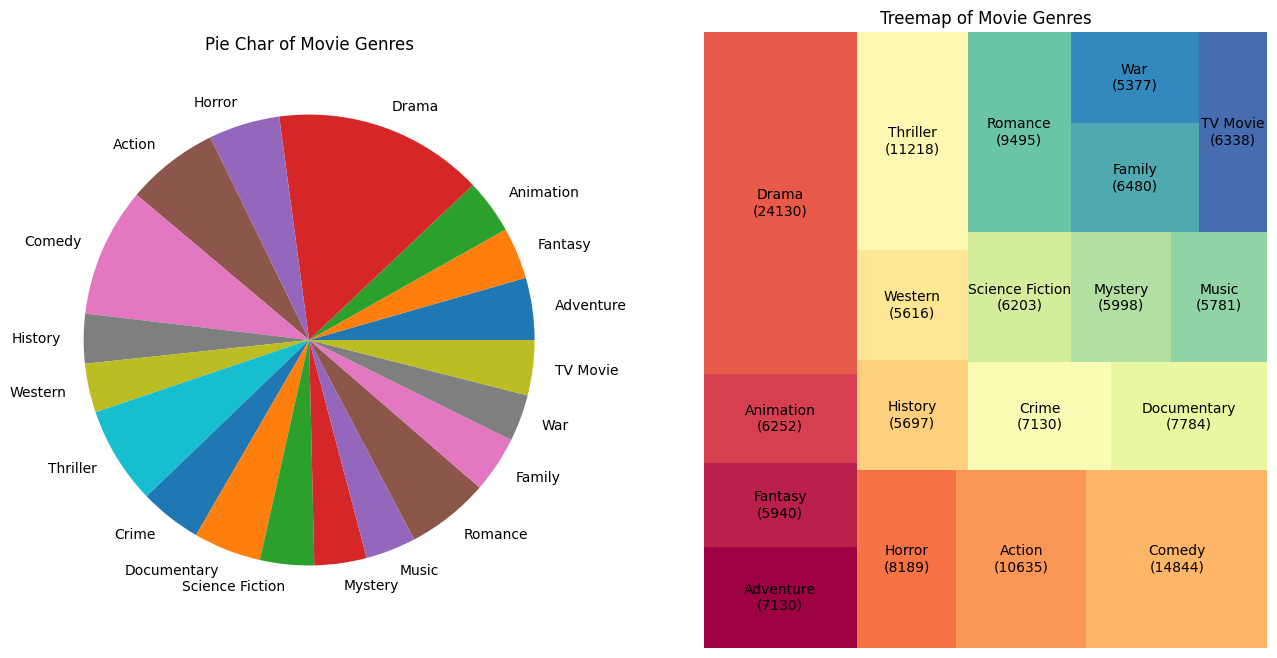

In [48]:
import matplotlib.pyplot as plt
import squarify

data_sum = data[[str(i) for i in id2genre.keys()]].sum().reset_index(name="counts")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pie(data_sum["counts"], labels=id2genre.values())
plt.title("Pie Char of Movie Genres")

plt.subplot(122)
squarify.plot(
    sizes=data_sum["counts"].values.tolist(),
    label=data_sum.apply(lambda x: f"{id2genre[x[0]]}\n({x[1]})", axis=1),
    color=[plt.cm.Spectral(i / float(len(id2genre))) for i in range(len(id2genre))],
)
plt.title("Treemap of Movie Genres")
plt.axis("off")
plt.show()

## Word Frequency

In terms of the NLP task, we want to predict the movie genres using its overview. It's natural to check the word frequency so we can have a better understanding of the overview contents.


In [49]:
import string
from collections import Counter
from wordcloud import STOPWORDS

# lowcase & remove punctuations
content = " ".join(data["overview"]).lower()
content = content.translate(str.maketrans("", "", string.punctuation)).split()

word_count = Counter(content)

In this section, we find the 80 most frequent words of all collected overviews and then delete the common words in it because they may not make much sense. The bar plot of word frequency is shown as below.


In [50]:
print(f"Common Words: {', '.join(STOPWORDS)}")

Common Words: what's, from, yours, hadn't, until, while, down, he'll, these, and, hasn't, ourselves, where's, i'd, through, any, their, since, in, wasn't, don't, you, www, or, can, won't, hence, like, more, shall, it, just, once, could, shouldn't, what, ours, but, that, before, am, also, it's, than, over, they're, your, we'd, too, below, themselves, does, i, up, under, she, we'll, they, they'd, to, other, between, him, by, about, nor, further, haven't, is, theirs, been, there's, however, few, so, my, her, during, the, whom, itself, most, else, with, yourselves, same, they've, therefore, didn't, she'd, mustn't, which, he, for, were, had, all, into, would, where, those, its, aren't, myself, some, his, above, here, weren't, she's, why, shan't, an, couldn't, hers, com, can't, being, ought, he'd, you're, that's, doing, have, here's, yourself, doesn't, isn't, them, as, should, did, they'll, why's, himself, only, you'll, such, after, when's, because, i'm, at, own, let's, do, was, we're, who's

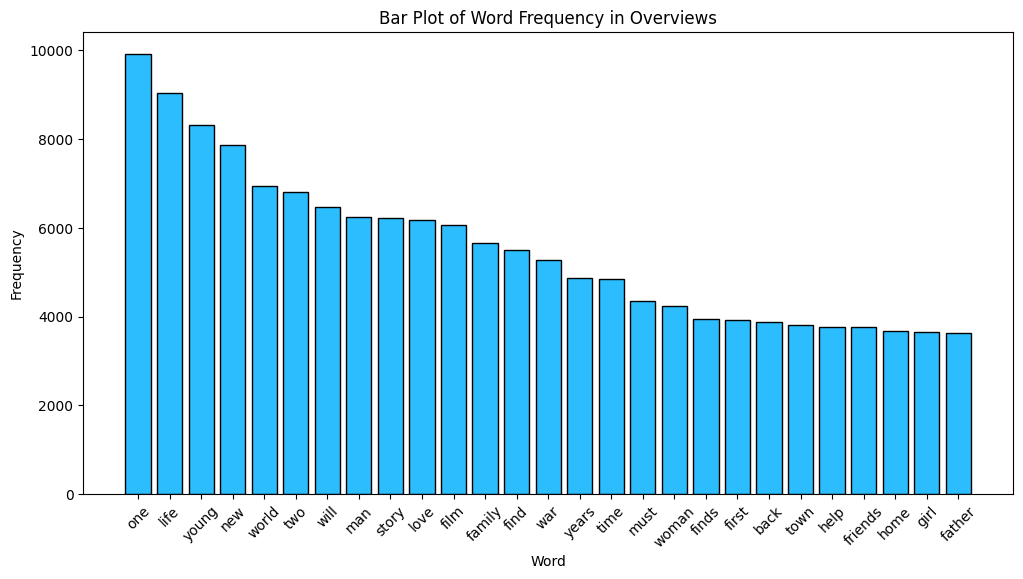

In [51]:
word_freq = dict(word_count.most_common(80))
word_freq = {i: j for i, j in word_freq.items() if i not in STOPWORDS}

plt.figure(figsize=(12, 6))
plt.bar(word_freq.keys(), word_freq.values(), color="#2cbdfe", edgecolor="black")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title(f"Bar Plot of Word Frequency in Overviews")
plt.xticks(rotation=45)
plt.show()

As we can see in the plot, the most frequent words consist of the words relating to the main characters and the theme of movies. Specifically, **one**, **two** and other quantifiers are used to indicate the number of main characters generally; **young**, **man** and **girl** are used to indicate their characteristics (gender, age and etc.) while **love**, **world** and **war** are in connection with the movie themes. According to the definition, "film genres are usually delineated by '_conventions_, _iconography_, _settings_, _narratives_, _characters_ and _actors_.'" Given that the overview contains these factors, we believe that it’s viable to predict the movie genre utilizing its plot overview.

A short example is shown as below which consists of "war", "one" and "man" as mentioned before:


In [52]:
print(data["overview"][69])

As a collection of history's worst tyrants and criminal masterminds gather to plot a war to wipe out millions, one man must race against time to stop them.


This part shows the frequency of these words showing in different genres to see whether movies of different genres have different key words in overview. We will dive into this later in the word cloud section.


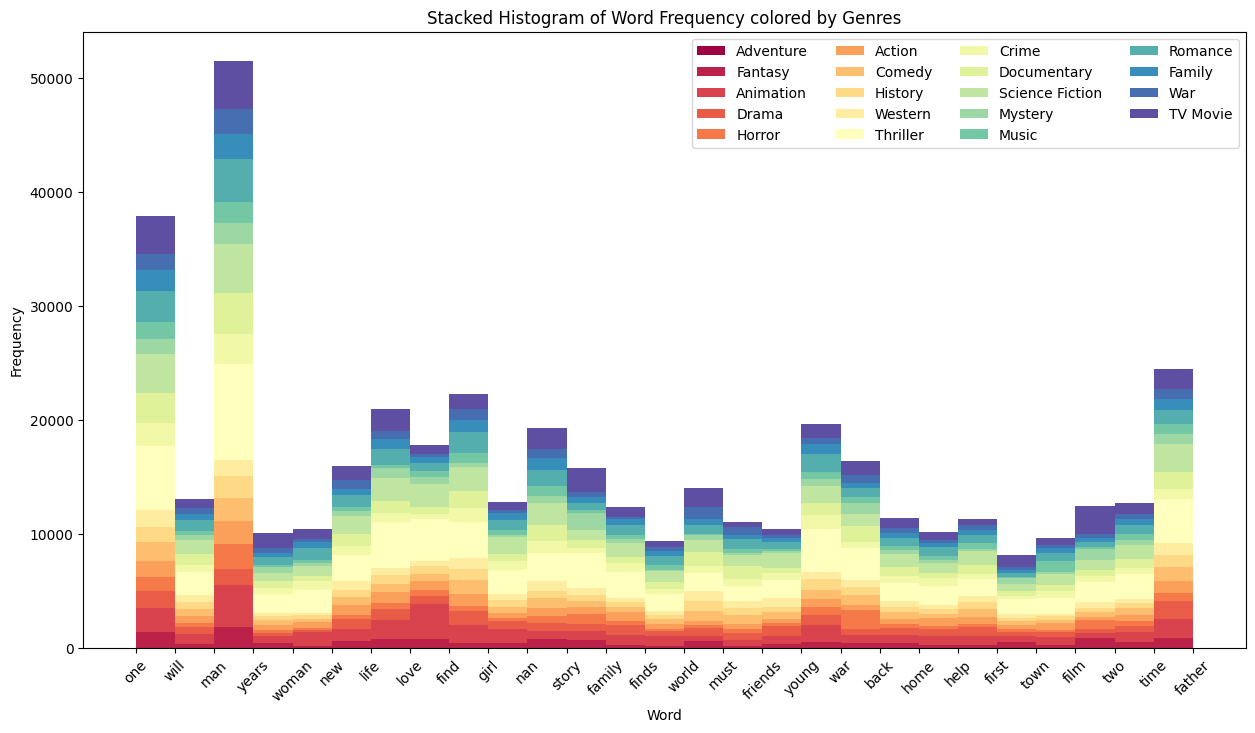

In [53]:
data_freq = data[["genre_ids"]].copy(deep=True)
data_freq["genres"] = data_freq["genre_ids"].map(lambda x: x[1:-1].split(", "))
data_freq["words"] = data["overview"].map(
    lambda x: [i for i in word_freq.keys() if i in x]
)
data_freq = (
    data_freq[["genres", "words"]].explode("genres").explode("words").groupby("genres")
)
color = [
    plt.cm.Spectral(i / float(len(id2genre) - 1)) for i in range(len(id2genre) + 1)
]


plt.figure(figsize=(15, 8))
plt.hist(
    [x["words"].values.tolist() for _, x in data_freq],
    len(word_freq),
    stacked=True,
    color=color,
)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title(f"Stacked Histogram of Word Frequency colored by Genres")
plt.xticks(rotation=45)
plt.legend({group: col for group, col in zip(id2genre.values(), color)}, ncol=4)
plt.show()

## Word Cloud

In this section, we want to draw the word cloud graphs for every movie genre and see whether the most frequent words can reflect the characteristics of different genres.


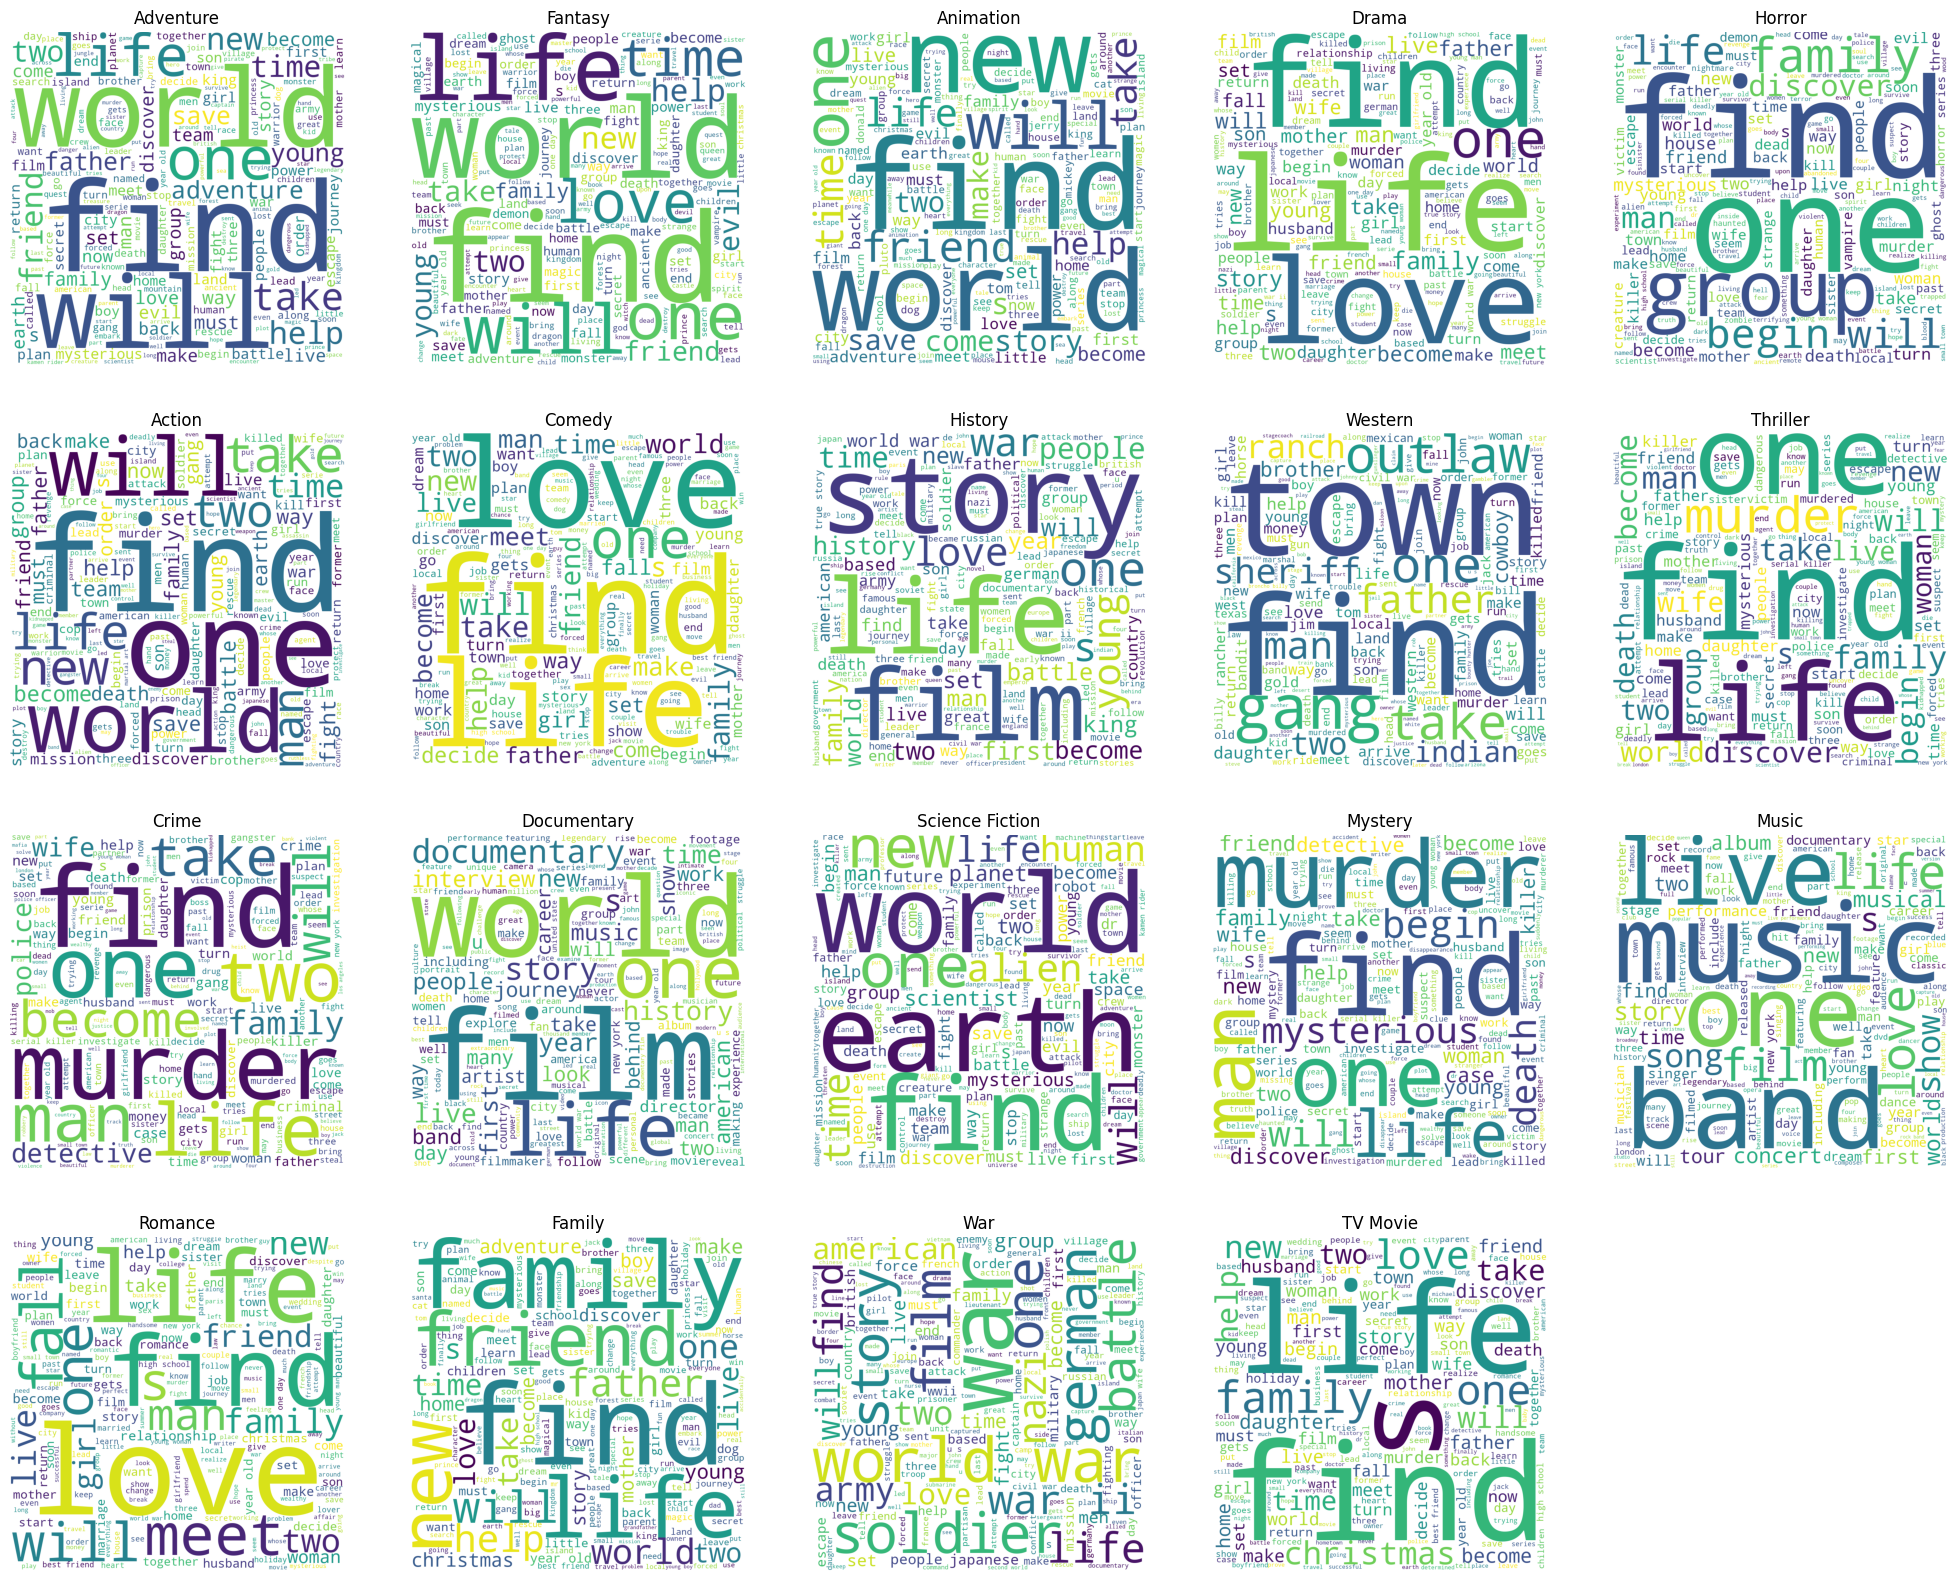

In [54]:
from wordcloud import WordCloud

plt.figure(figsize=(25, 20))

for i, (id, value) in enumerate(id2genre.items()):

    plt.subplot(4, 5, i + 1)
    content = "".join(data[data[id] == 1]["overview"]).lower()
    word_cloud = WordCloud(width=1000, height=1000, background_color="white").generate(
        content
    )
    plt.imshow(word_cloud)
    plt.title(value)
    plt.axis("off")

plt.show()

Other than the common words like "find" and "world", the most frequent words do have to do with genres.

For example, with regard to the "history" movies (2th row, 3th col), **story** is one of the most frequent words while this kind of movies tend to tell the stories of history events. In addition, **murder**, **death** and **detective** are common elements in the "thriller" (2th row, 5th col), "crime" (3th row, 1th col) and "mystery" movies (3th row, 4th col). As to the "war" movies (4th row, 3th col), it's easy to understand that military-related words like **soldier**, **battle** and **army** appear in its word cloud graph.

All in all, it looks reasonable to use the overview to predict the genre of movies.


## Correlation Heatmap

In this section, we are intended to check the correlation between different genres to make sure that genres are not too similar to effect the classifcation performance.

First of all, we check the number of frequency of simultaneous appearance of different genres so we can have a look at the relationship between the attributes roughly but visually.

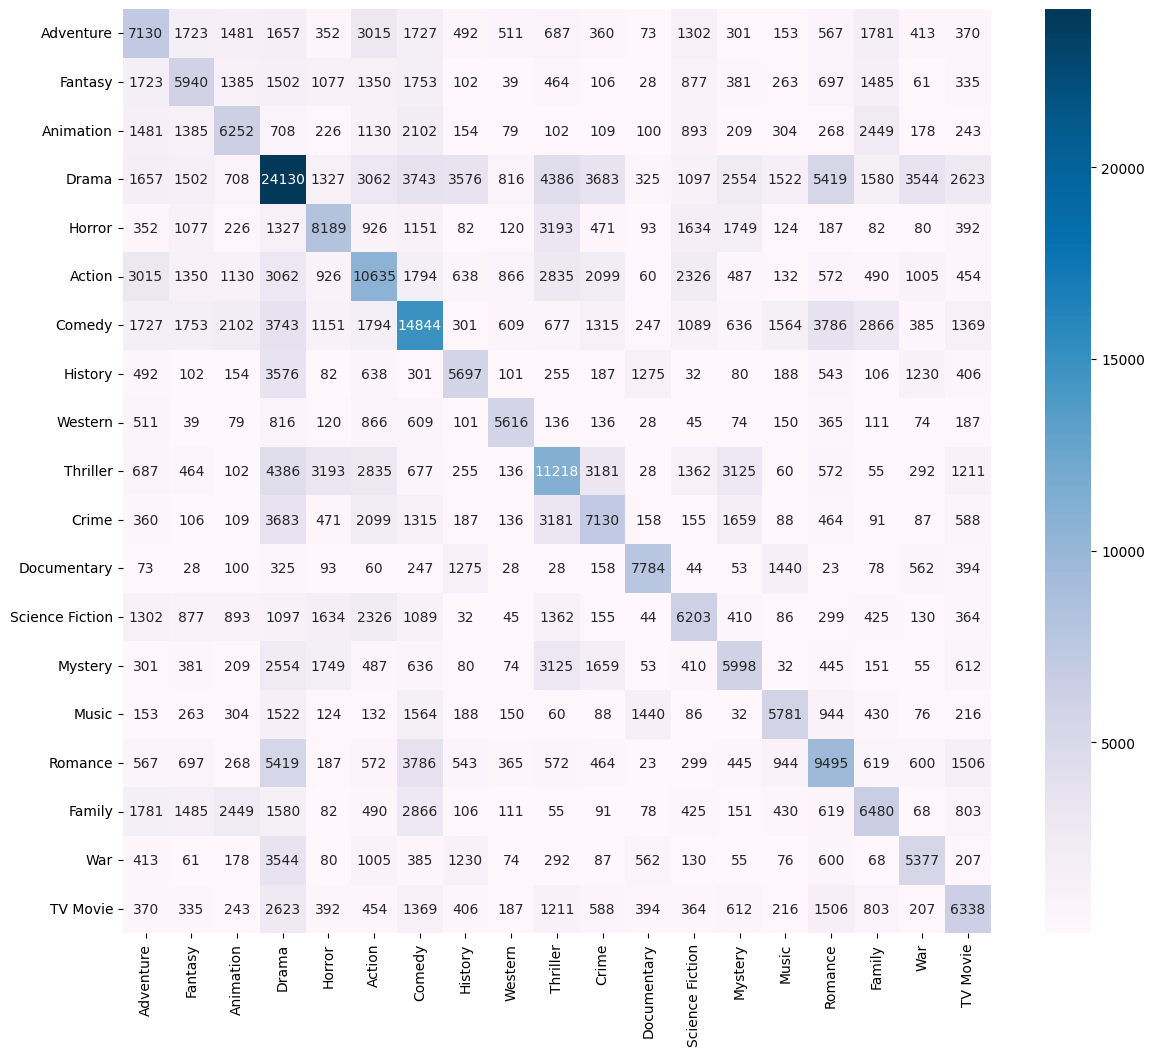

In [55]:
import seaborn as sns

data_genres = data[id2genre.keys()]

genre_count = []
for i in id2genre.keys():
    temp_count = []
    for j in id2genre.keys():
        temp_count.append(
            data_genres[(data_genres[i] == 1) & (data_genres[j] == 1)].shape[0]
        )
    genre_count.append(temp_count)

plt.figure(figsize=(14, 12))

sns.heatmap(
    pd.DataFrame(genre_count),
    xticklabels=id2genre.values(),
    yticklabels=id2genre.values(),
    annot=True,
    cmap="PuBu",
    fmt="d",
)
plt.show()

As we can see in the heatmap, the value in the *i*-th row, *j*-th col indicates the number of movies belonging to both the *i*-th and *j*-th genres.

We can get some interesting insights from the heatmap, for example, there are 3015 movies that belongs to "Adventure" and "Action" while there are 7130 "Adventure" moives and 10635 "Action" moives. That's easy to understand: in the adventure movie, the main character needs to defeat the guards and competitors in order to finally get the treasure or complete the mission like the "Mission: Impossible" series. As a result, we need to further determine whether the different genres will be too similar in terms of statistical significance.

Because these genre attributions are categorical (binary) variable instead of numeric variables, the common Pearson correlation coefficient doesn't make much sense which is used to reflect the linear correlation between variables. And we choose to use the Cramér's V here to measure the association between nominal variables.

Max Value: 0.32054256393174346, Min Value: 0.0


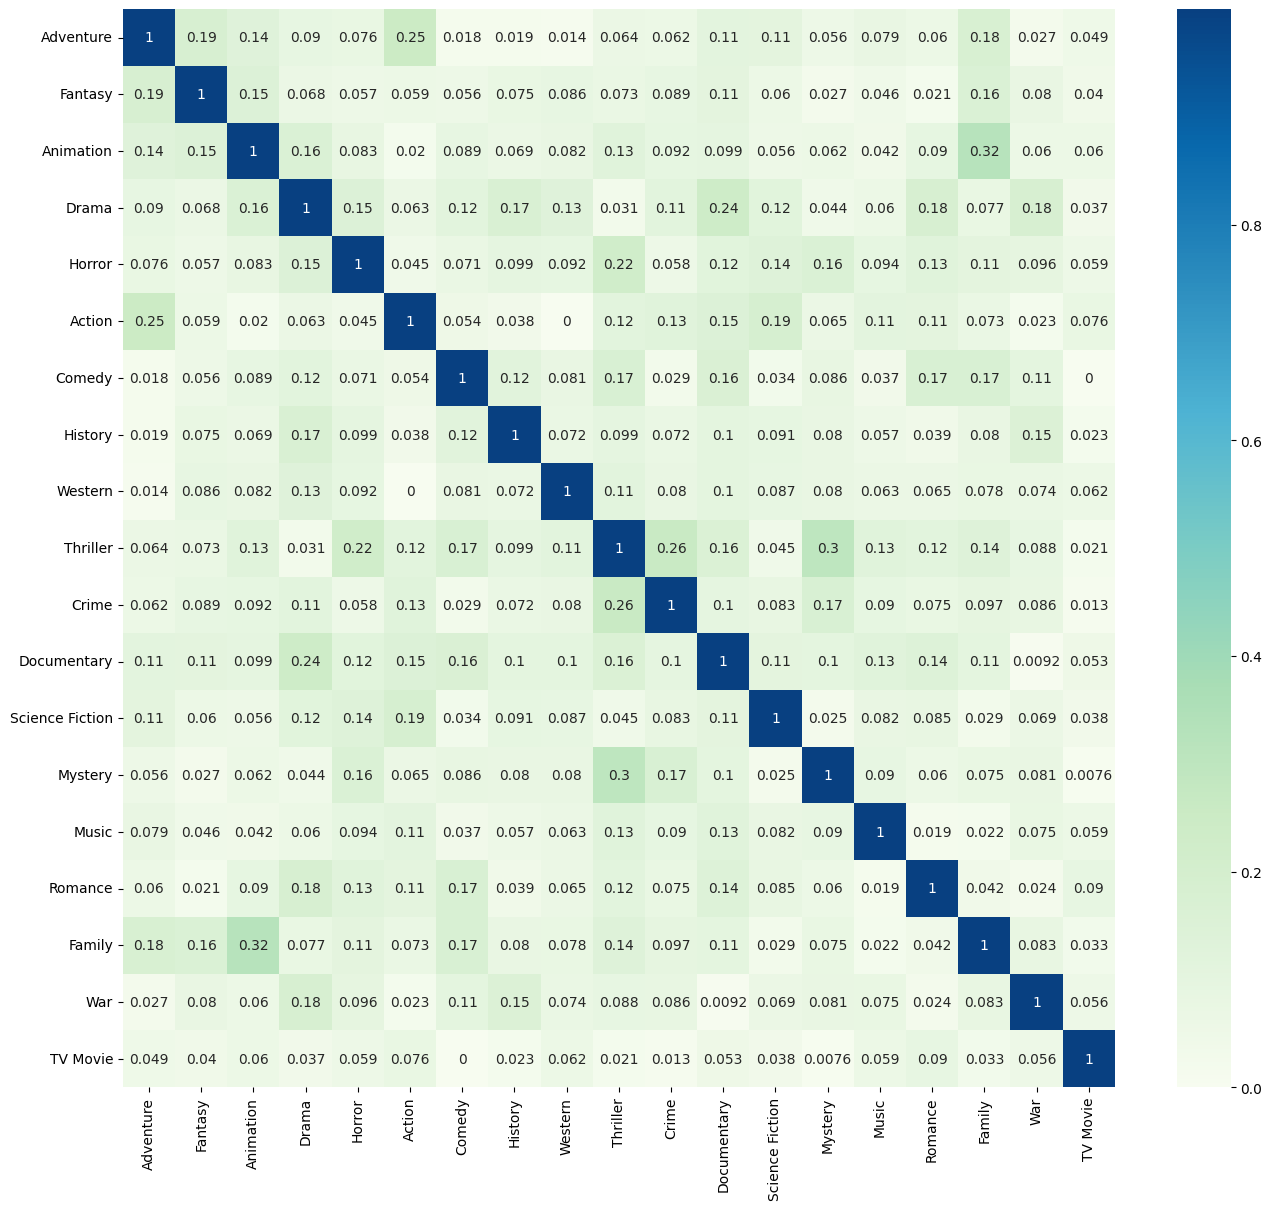

In [56]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


data_corr = []
max_corr, min_corr = -np.inf, np.inf

for i in id2genre.keys():
    temp = []
    for j in id2genre.keys():
        value = cramers_v(data_genres[i], data_genres[j])
        temp.append(value)
        if i != j:
            max_corr = max(max_corr, value)
            min_corr = min(min_corr, value)
    data_corr.append(temp)



print(f"Max Value: {max_corr}, Min Value: {min_corr}")

plt.figure(figsize=(16, 14))
sns.heatmap(
    pd.DataFrame(data_corr),
    xticklabels=id2genre.values(),
    yticklabels=id2genre.values(),
    annot=True,
    cmap="GnBu",
)
plt.show()

As we can see from the result, the maximum value is around 0.32 which is related to the animation and family. It is small so we can think all these genres are not independent from each other.